In [61]:
from matplotlib import pyplot as plt
from matplotlib import dates as mpl_dates
# import matplotlib.dates as mdates
import yfinance as yf
import pandas as pd
import numpy as np
from helpers import Trade
import os

plt.style.use('Solarize_Light2')

In [62]:
TICKERS = [
    "GC=F",
    "NQ=F",
    "YM=F",
]

end_date = '2024-10-08'

start_date = pd.to_datetime(end_date)-pd.DateOffset(364 * 2)

if os.path.exists("global-data.csv"):
    df = pd.read_csv("global-data.csv")
    df['Datetime'] = pd.to_datetime(df['Datetime'], utc=True)
    df.set_index(['Datetime', 'Ticker'], inplace=True)
else:
    df = yf.download(tickers=TICKERS, start=start_date, end=end_date, interval="1h").stack(future_stack=True)
    df.drop(columns=['Volume', 'Adj Close'], inplace=True)
    df.to_csv("global-data.csv")

df.columns = df.columns.str.lower()

df.head(len(TICKERS) * 2)

close          high       low  \
Datetime                  Ticker                                         
2022-10-11 04:00:00+00:00 GC=F     1670.000000   1671.900024   1668.50   
                          NQ=F    10926.250000  10947.250000  10913.25   
                          YM=F    29091.000000  29132.000000  29068.00   
2022-10-11 05:00:00+00:00 GC=F     1673.099976   1673.500000   1669.50   
                          NQ=F    10927.500000  10940.500000  10916.75   
                          YM=F    29103.000000  29126.000000  29074.00   

                                          open  
Datetime                  Ticker                
2022-10-11 04:00:00+00:00 GC=F     1670.699951  
                          NQ=F    10936.750000  
                          YM=F    29105.000000  
2022-10-11 05:00:00+00:00 GC=F     1669.900024  
                          NQ=F    10926.500000  
                          YM=F    29093.000000

- Loading constants

In [63]:
import json

with open('global.params.json', 'r') as file:
    PARAMS = json.load(file)

FIGSIZE = PARAMS['FIGSIZE']
SIGNALS = PARAMS['SIGNALS']
POSITIONS_NATURE = PARAMS['POSITIONS_NATURE']
POSITIONS_SHORTCUT = PARAMS['POSITIONS_SHORTCUT']

# Creating needed Cols

In [64]:
WINDOW = 31

df['Mean'] = df.groupby(level=1)['close'].transform(lambda grouped: grouped.rolling(window=WINDOW).mean())
# df[f"EMA-{WINDOW}"] = df.groupby(level=1)['close'].transform(lambda grouped: grouped.ewm(span=WINDOW, adjust=False).mean())
df['STD'] = df.groupby(level=1)['close'].transform(lambda grouped: grouped.rolling(window=WINDOW).std())

df['Z-Score'] = np.where(
    df['high'] + df['low'] > 2 * df['Mean'],
    (df['high'] - df['Mean']) / df['STD'],
    (df['low'] - df['Mean']) / df['STD']
)

df['Mean'] = df.groupby(level=1)['Mean'].shift(1)
df['STD'] = df.groupby(level=1)['STD'].shift(1)
df['Z-Score'] = df.groupby(level=1)['Z-Score'].shift(1)

df.dropna(inplace=True)

df.head(3)

close          high           low  \
Datetime                  Ticker                                             
2022-10-12 12:00:00+00:00 GC=F     1678.599976   1679.300049   1671.400024   
                          NQ=F    10888.000000  10967.750000  10852.000000   
                          YM=F    29298.000000  29482.000000  29262.000000   

                                          open          Mean         STD  \
Datetime                  Ticker                                           
2022-10-12 12:00:00+00:00 GC=F     1675.300049   1675.248386    4.745790   
                          NQ=F    10940.000000  10903.895161   43.308716   
                          YM=F    29399.000000  29287.548387  162.884179   

                                   Z-Score  
Datetime                  Ticker            
2022-10-12 12:00:00+00:00 GC=F    0.621934  
                          NQ=F    1.289690  
                          YM=F    1.046459

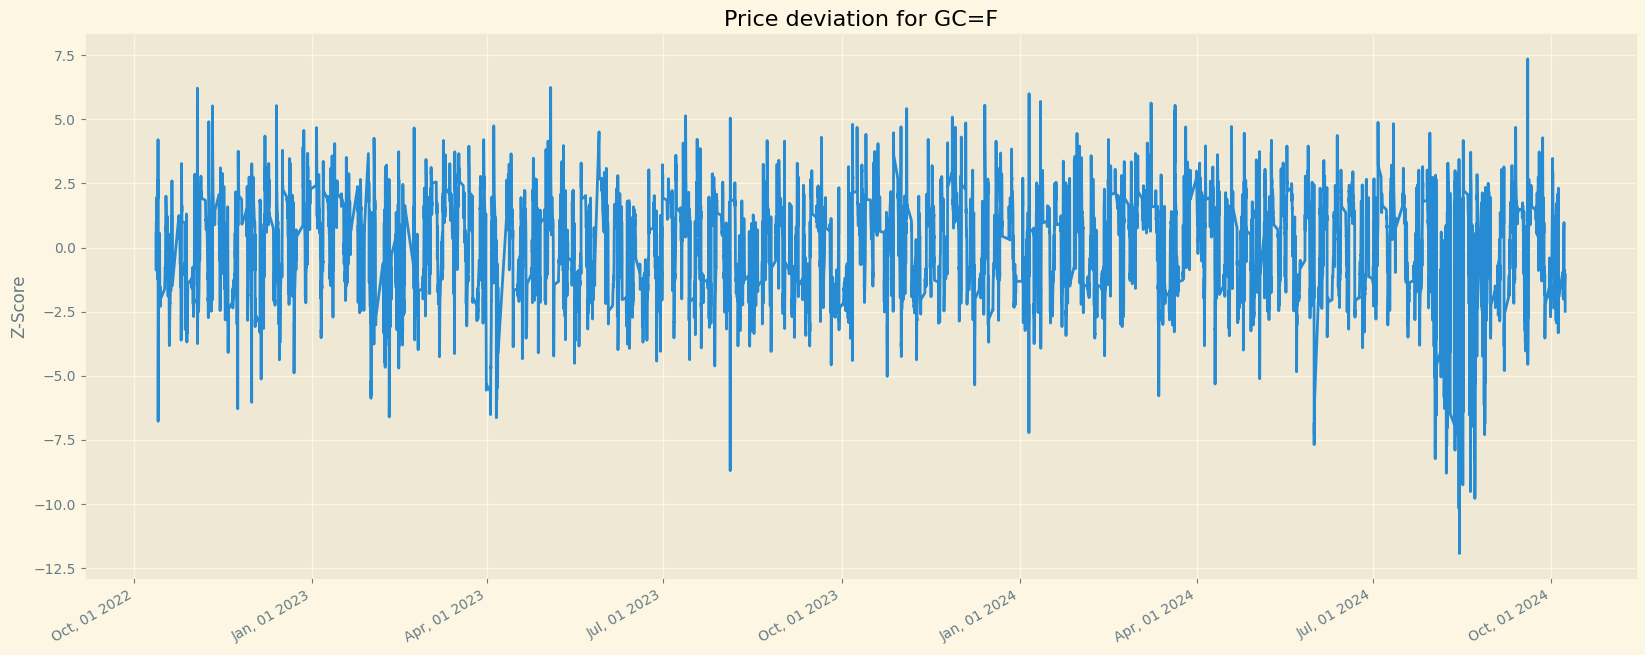

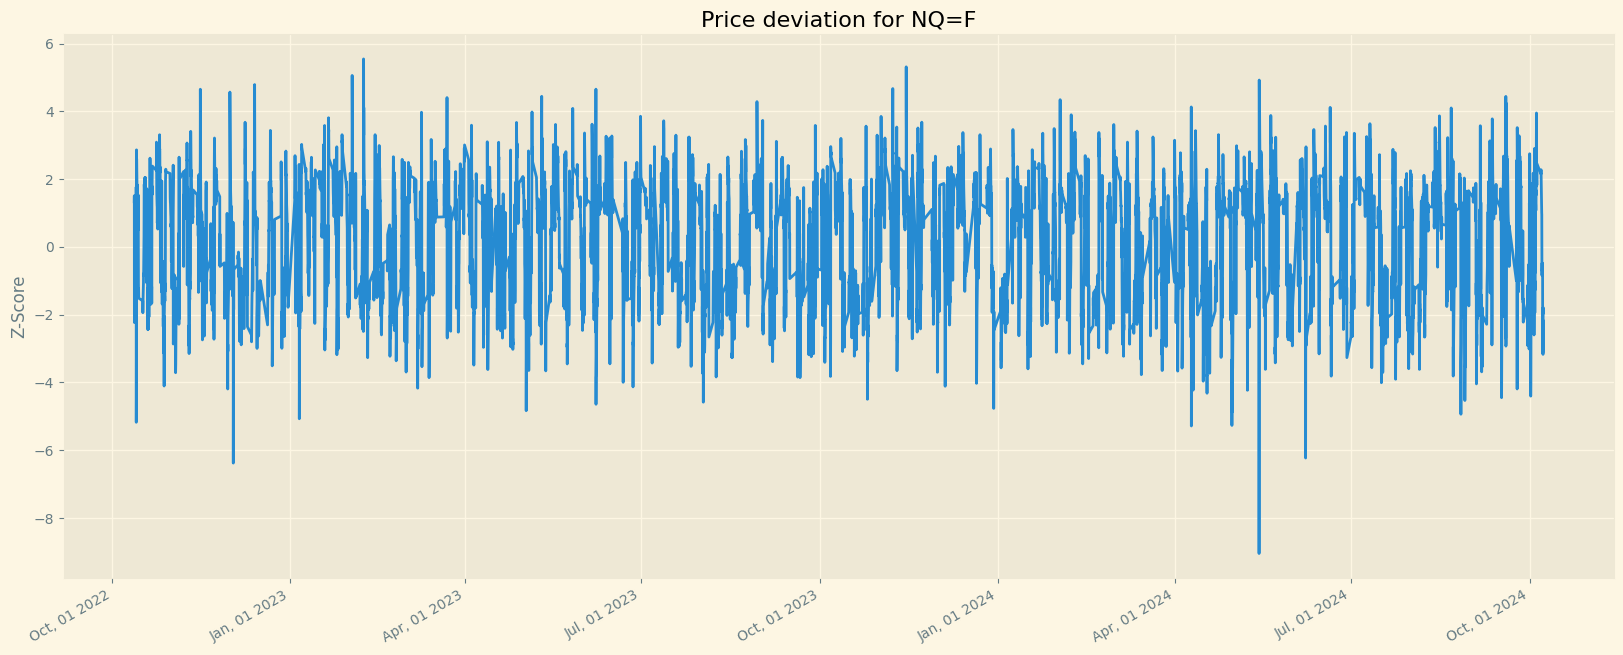

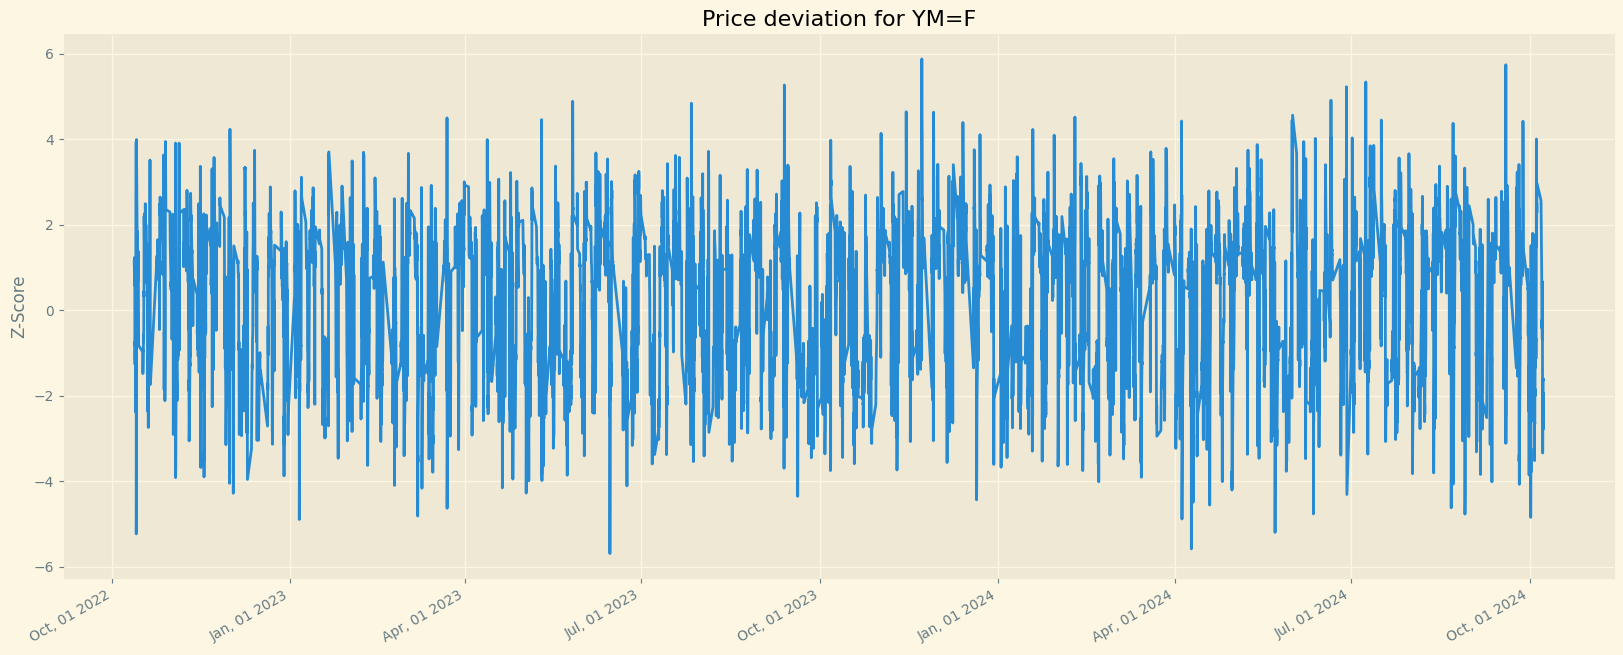

In [65]:
for name, group in df.groupby(level=1)['Z-Score']:
    group.index = [dt for (dt, _) in group.index]
    group.plot(kind='line', xlabel='', ylabel="Z-Score", figsize=(FIGSIZE['WIDTH'],FIGSIZE['HEIGHT'] + 3), title=f'Price deviation for {name}')

    plt.gcf().autofmt_xdate()
    plt.gca().xaxis.set_major_formatter(mpl_dates.DateFormatter("%b, %d %Y"))

    plt.show()

# Generating Buy/Sell signals

In [70]:
df['Signal'] = 0  # Default to hold/no position

# df.xs('GC=F', level=1)['Z-Score']

for name  in TICKERS:
    price_deviate_over_xSTD_filter = (df.index.get_level_values('Ticker') == name) & (df['Z-Score'] > PARAMS[name]['HIGHER_PRICE_DEVIATION']['ENTRY'])
    price_deviate_under_xSTD_filter = (df.index.get_level_values('Ticker') == name) & (df['Z-Score'] < -PARAMS[name]['LOWER_PRICE_DEVIATION']['ENTRY'])

    df.loc[price_deviate_under_xSTD_filter, 'Signal'] = SIGNALS['BUY'] # Buy signal
    df.loc[price_deviate_over_xSTD_filter, 'Signal'] = SIGNALS['SELL']  # Sell signal

# df[df['Signal'] > 0]
# df[df['Signal'] < 0]

,,close,high,low,open,Mean,STD,Z-Score,Signal
Datetime,Ticker,,,,,,,,
2022-10-13 12:00:00+00:00,GC=F,1660.599976,1685.500000,1650.300049,1685.300049,1678.151611,2.557843,4.202139,-1
2022-11-02 19:00:00+00:00,GC=F,1639.500000,1655.300049,1637.800049,1652.300049,1653.329042,3.181109,6.215107,-1
2022-11-08 16:00:00+00:00,GC=F,1718.599976,1720.400024,1715.699951,1716.400024,1678.554845,7.922327,4.903254,-1
2022-11-10 14:00:00+00:00,GC=F,1747.500000,1748.800049,1736.300049,1736.900024,1712.570970,5.148482,5.521828,-1
2022-11-10 15:00:00+00:00,GC=F,1754.500000,1757.199951,1747.199951,1747.599976,1713.687098,8.116889,4.325912,-1
...,...,...,...,...,...,...,...,...,...
2024-09-19 01:00:00+00:00,NQ=F,19505.250000,19506.000000,19446.000000,19487.750000,19452.491935,37.426399,4.235194,-1
2024-09-26 12:00:00+00:00,GC=F,2700.300049,2707.300049,2691.399902,2706.000000,2684.535495,5.648313,4.278172,-1
2024-09-27 15:00:00+00:00,YM=F,42913.000000,43004.000000,42892.000000,42904.000000,42542.677419,84.986817,4.416245,-1
